# Analyzing Sentiment Data Against Stock Data

To simply show the ability to use sentiment to trade stocks I used backtrader a special python package which which allows you to feed stock prices, and design a special strategy to execute buy and sell on stocks at a given price. It also has built in methods for have a total portfolio value, commision fees, broker fees, etc.

I was able to find a solution for using sentiment to trade, I made a few changes but the overall program was provided by a Jason Yip, through a medium post. 
- https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704

- I wrote a script to deploy the code, but its unfinished as I was still fine tuning strategies, but it is part of the package I created.
- I have copied and pasted this code in the notebook

In [88]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten

In [2]:
#import custom scripts to simplify model processing and vectorization
#install with pip install -e financialTextProcessing
from financialTextProcessing.loadStockInfo import loadStockInfo as loadStock
import financialTextProcessing.textProcessing as tp
from financialTextProcessing.createWord2Vec import word2vec
from financialTextProcessing.modeling import modeling
import financialTextProcessing.plotBacktrade as plotBt

import backtrader as bt

In [3]:
# prepare historical data
#load stock info
stock_info = loadStock("../data/stock_info/stocks/", "../data/stock_info/symbols_valid_meta.csv", DEBUG=True)
#load stock historical data from csvs
stock_df = stock_info.loadStockDf()
#rename stock_df columns
stock_df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'symbol', 'name']

In [6]:
stock_df.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume       float64
symbol        object
name          object
dtype: object

In [21]:
# prepare current data of Facebook Stock for Example
fb_curr_stock_df = pd.read_csv('data/fb_stock_04012020_06212020.csv')
curr_news_df = pd.read_csv('data/news_last_2_months_FB_AMZN_GOOG_MSFT.csv', index_col=0)
fb_curr_news_df = curr_news_df[curr_news_df['ticker'] == 'FB']

In [28]:
fb_curr_news_df['date'] = pd.to_datetime(fb_curr_news_df['date'])

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
fb_curr_stock_df['Date'] = pd.to_datetime(fb_curr_stock_df['Date'])

In [34]:
fb_curr_stock_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [37]:
#rename stock columns
fb_curr_stock_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

In [43]:
#build date_sentiment dict for plotting
#set max_len of article headlines
tk = Tokenizer(lower=True, filters=string.punctuation, split=' ')
max_len = 25

tk.fit_on_texts(fb_curr_news_df['title'])

#get tokenized titles
tokenized_title = tk.texts_to_sequences(fb_curr_news_df['title'])
tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)

In [47]:
#build predictions for latest news
model = load_model("model/SimpleRNN_pretrain.h5")

predictions = np.round(model.predict(tokenized_title_X))

In [49]:
#create data frame with predictions
new_predictions = pd.DataFrame(predictions, columns=['is_negative', 'is_neutral', 'is_positive'])

In [52]:
fb_curr_news_df = fb_curr_news_df.join(new_predictions)

In [53]:
fb_curr_news_df = fb_curr_news_df.astype({'is_negative': 'float', 'is_neutral': 'float', 'is_positive': 'float'})

In [55]:
#create sentiment columns for getting mean per day
fb_curr_news_df['sentiment'] = None
fb_curr_news_df['sentiment'] = np.where(fb_curr_news_df['is_positive'] == 1, 1, fb_curr_news_df['sentiment'])
fb_curr_news_df['sentiment'] = np.where(fb_curr_news_df['is_negative'] == 1, -1, fb_curr_news_df['sentiment'])
fb_curr_news_df['sentiment'] = np.where(fb_curr_news_df['is_neutral'] == 1, 0, fb_curr_news_df['sentiment'])
fb_curr_news_df = fb_curr_news_df.astype({'sentiment': 'float'})

In [57]:
#get grouped by date
grouped_fb_news_df = fb_curr_news_df.groupby('date').mean().round(3)['sentiment']
date_sentiment_df = grouped_fb_news_df.to_dict()

In [69]:
#for plotting
date_sentiment = {}

for k in date_sentiment_df:
    date_sentiment[pd.to_datetime(k).date()] = round(date_sentiment_df[k],3)

earliest_date = min(date_sentiment.keys())

In [67]:
fb_curr_stock_df.dtypes

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
dtype: object

In [100]:
from __future__ import (absolute_import, division, print_function,unicode_literals)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import backtrader as bt
import backtrader.indicators as btind
from backtrader import plot
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        else:
            self.sentiment = 0.0
        self.lines.sentiment[0] = self.sentiment

class SentimentStrat(bt.Strategy):
    params = (
        ('period', 10),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        if self.sentiment:
            self.log('Close, %.2f - Sentiment, %.2f' % (self.dataclose[0], self.sentiment))
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            #buy purely on significant increase from previous day to current
            if self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            #sell purely on significant decrease from previous day to current
            if self.sentiment-prev_sentiment <= -0.55:
                self.log('SELL CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' % (self.params.period, self.broker.getvalue()), doprint=True)

class plotCerebro:

    #functio provided by forum https://community.backtrader.com/topic/1190/save-cerebro-plot-to-file/2
    def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None, width=16, height=9, dpi=300, tight=True, use=None, file_path = '', **kwargs):
        if cerebro.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

        figs = []
        for stratlist in cerebro.runstrats:
            for si, strat in enumerate(stratlist):
                rfig = plotter.plot(strat, figid=si * 100,
                                    numfigs=numfigs, iplot=iplot,
                                    start=start, end=end, use=use)
                figs.append(rfig)

        for fig in figs:
            for f in fig:
                f.savefig(file_path, bbox_inches='tight')
        return figs

## Plotting Trained Sentiment Against Current Stock Data

Starting Portfolio Value: 100000.00
2020-04-16, Close, 176.25 - Sentiment, -0.80
2020-04-16, BUY CREATE, 176.25 - SENTIMENT 0.91
2020-04-17, BUY EXECUTED, Price: 179.20, Cost: 17920.00, Comm 17.92
2020-04-17, Close, 179.24 - Sentiment, 0.11
2020-04-21, Close, 170.80 - Sentiment, 0.15
2020-04-21, SELL CREATE, 170.80 - SENTIMENT -0.55
2020-04-22, SELL EXECUTED, Price: 178.45, Cost: 17920.00, Comm 17.84
2020-04-22, OPERATION PROFIT, GROSS -75.00, NET -110.77
2020-04-22, Close, 182.28 - Sentiment, -0.40
2020-04-23, Close, 185.13 - Sentiment, -0.10
2020-04-27, Close, 187.50 - Sentiment, 0.08
2020-04-28, Close, 182.91 - Sentiment, -0.09
2020-04-29, Close, 194.19 - Sentiment, 0.08
2020-04-30, Close, 204.71 - Sentiment, -0.22
2020-05-01, Close, 202.27 - Sentiment, 0.09
2020-05-04, Close, 205.26 - Sentiment, -0.09
2020-05-05, Close, 207.07 - Sentiment, 0.17
2020-05-07, Close, 211.26 - Sentiment, -0.29
2020-05-08, Close, 212.35 - Sentiment, -0.50
2020-05-08, BUY CREATE, 212.35 - SENTIMENT 0.50
2

<IPython.core.display.Javascript object>

[[<Figure size 3000x2400 with 4 Axes>]]

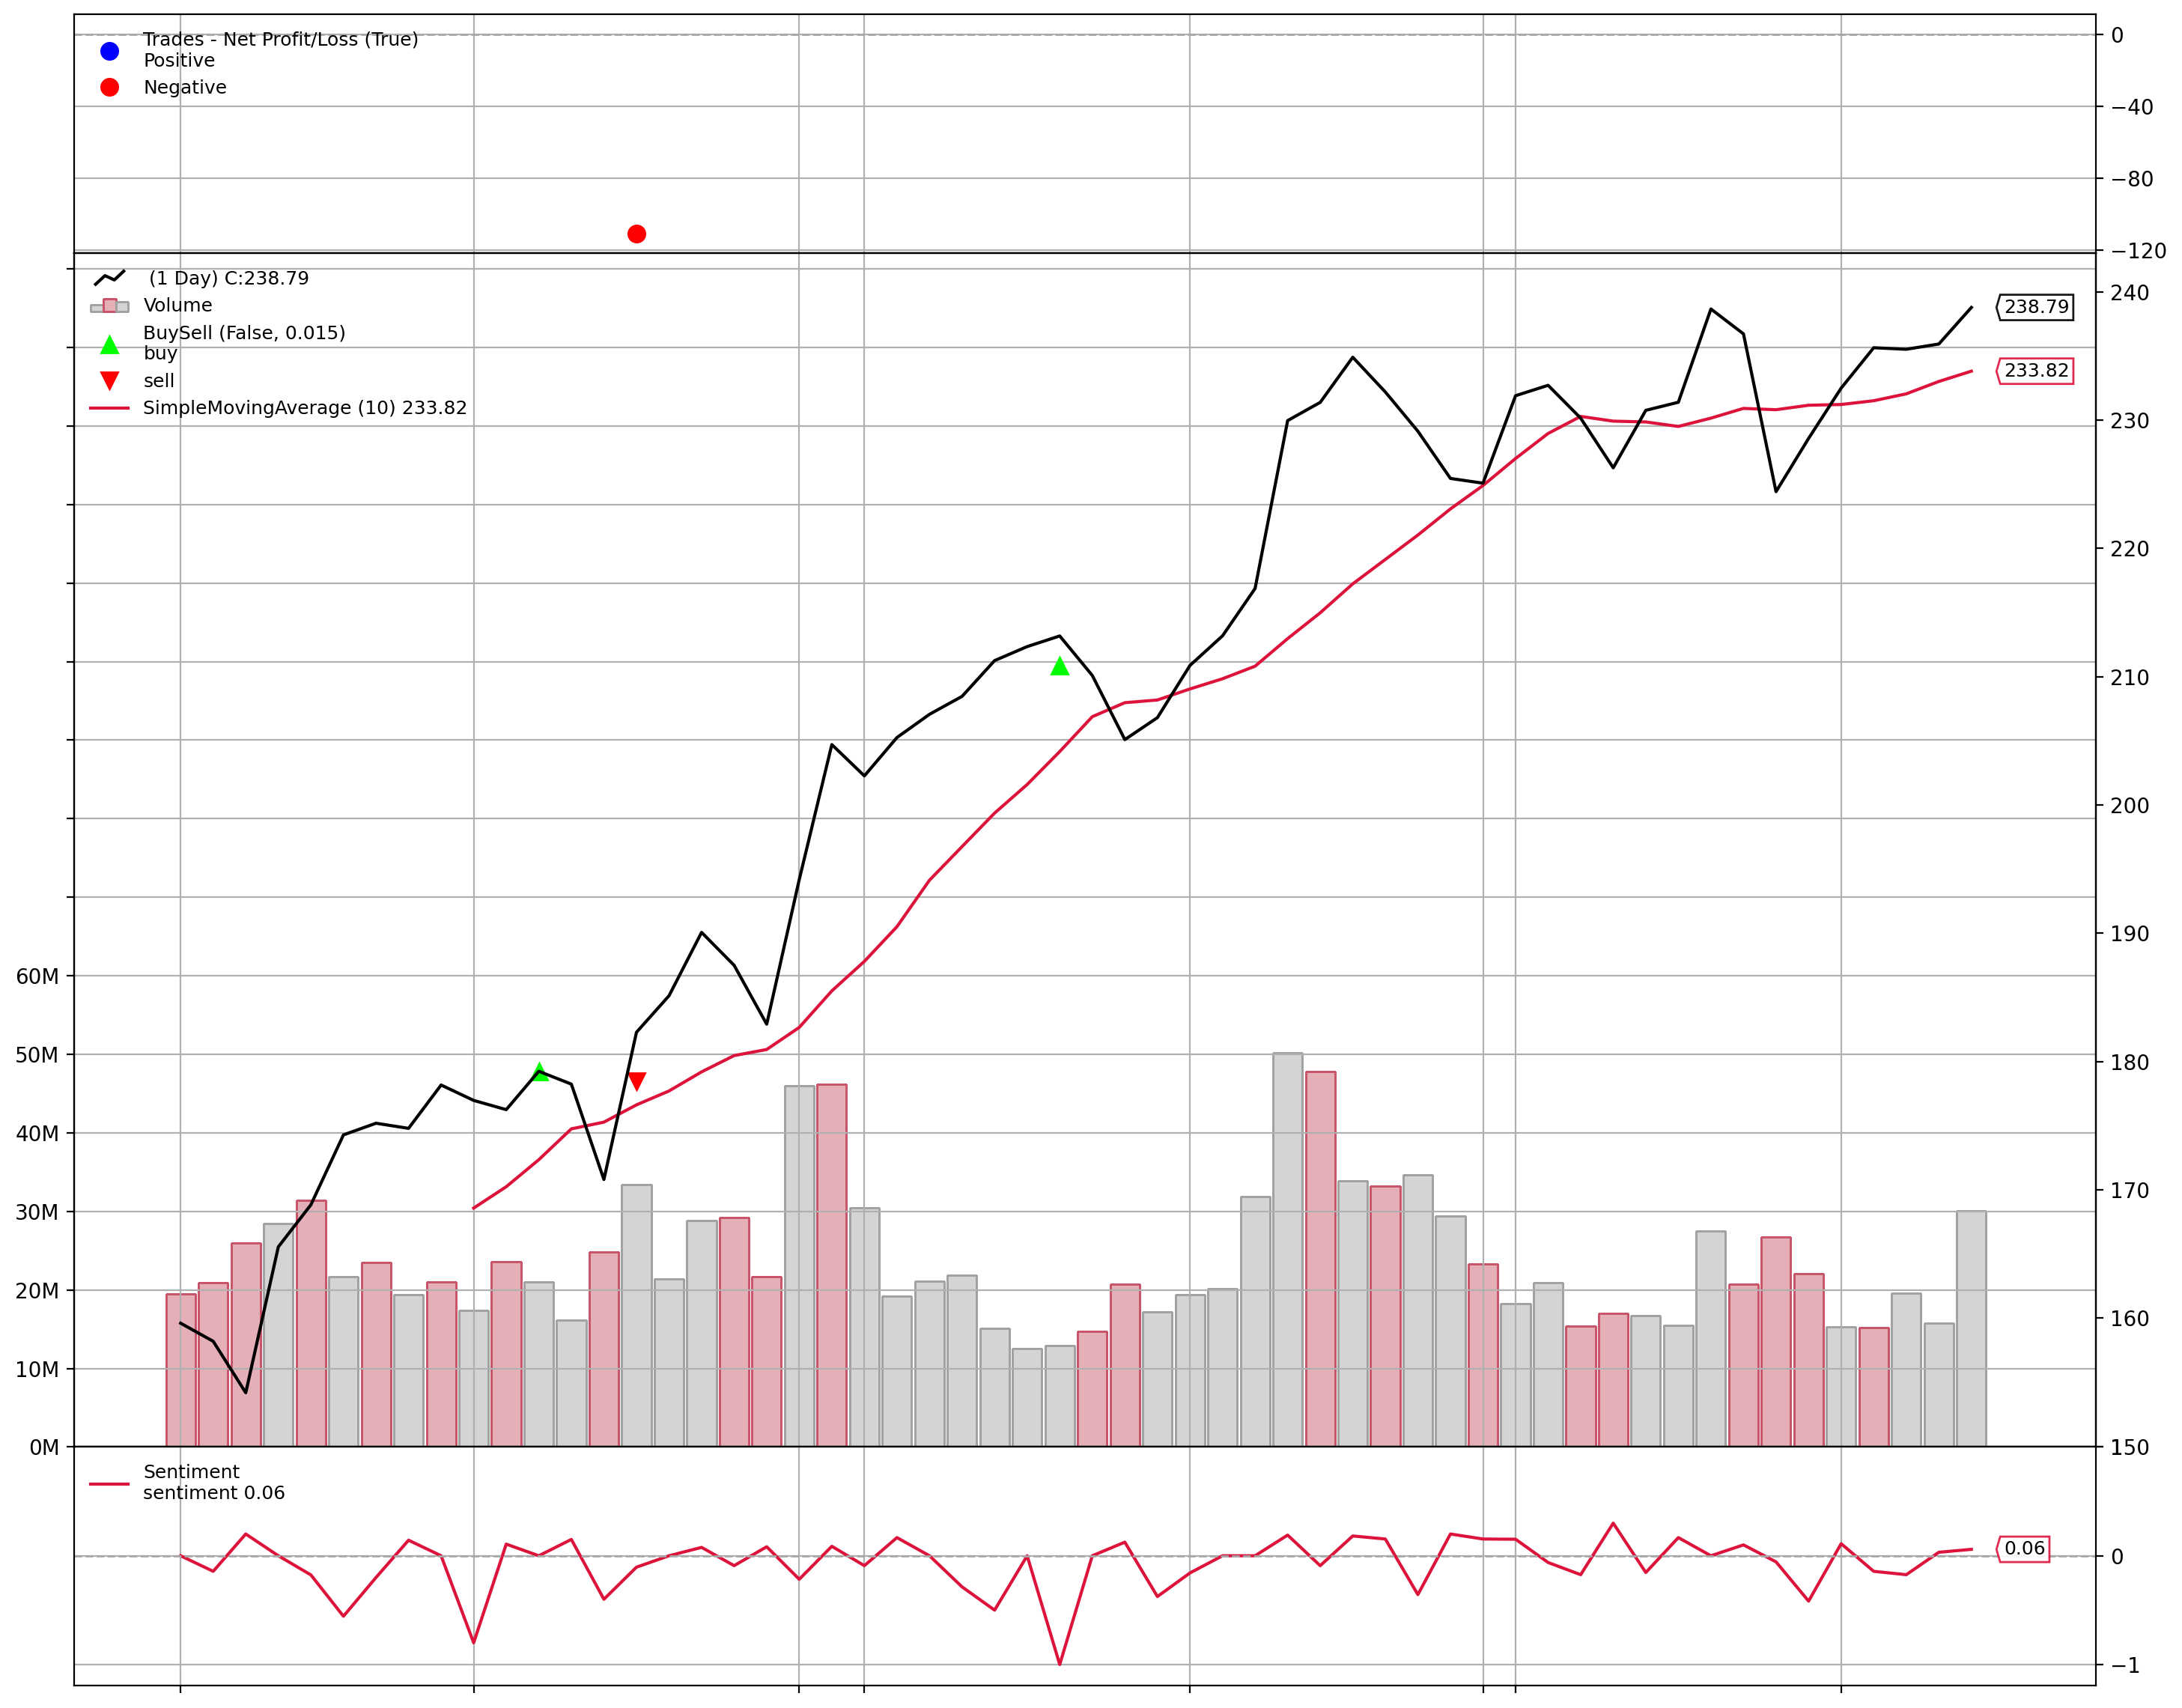

In [105]:
cerebro = bt.Cerebro(stdstats=False)

# Strategy
cerebro.addstrategy(SentimentStrat)

# Data Feed
data = bt.feeds.PandasData(dataname=fb_curr_stock_df.set_index('date'))

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=100)
cerebro.broker.setcommission(commission=0.001)

#print starting value of portfolio
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.run()

#set plot paramaters
plt.rcParams['figure.figsize']=[15, 12]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'

#print final protfolio value based on data given
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

dateTimeObj = datetime.datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")

#save plot to file
cerebro.plot()

## Analyzing Sentiment over Time

In [91]:
fb_curr_news_df.sort_values(by='date', inplace=True)

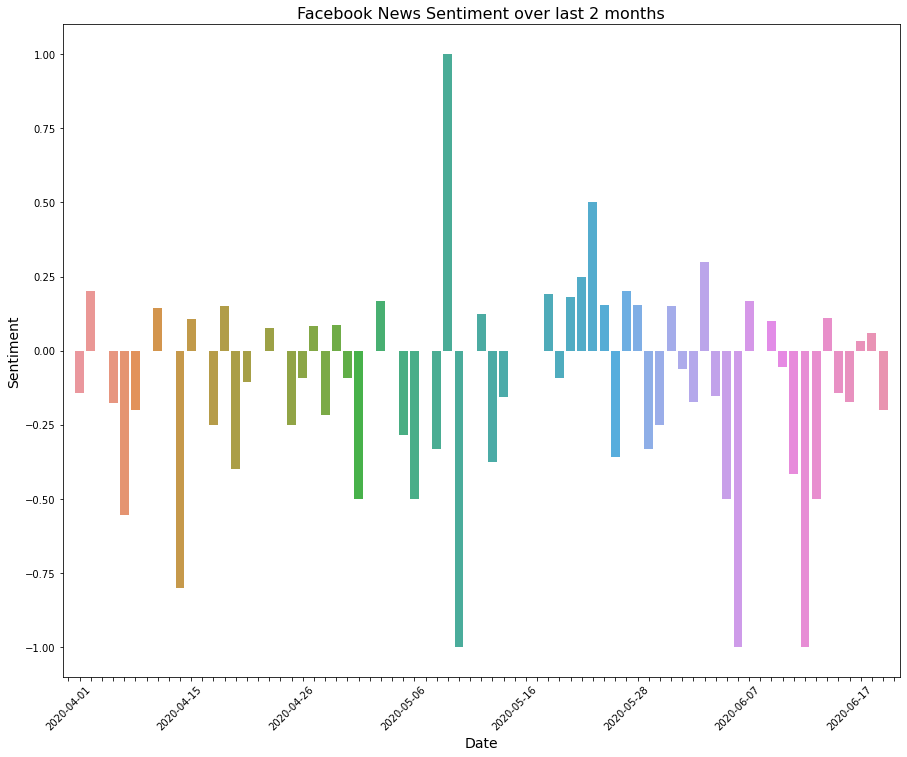

In [93]:
plt.figure(figsize=(15,12))
plot = sns.barplot(pd.to_datetime(fb_curr_news_df['date']).dt.date, fb_curr_news_df['sentiment'], ci=None)
plt.xticks(rotation=45)

for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title("Facebook News Sentiment over last 2 months", size=16)
plt.xlabel("Date", size=14)
plt.ylabel("Sentiment", size=14)
plt.show()

In [98]:
positive_sent_by_date = fb_curr_news_df.query('sentiment == "1"').groupby('date').count()['sentiment']
negative_sent_by_date = fb_curr_news_df.query('sentiment == "-1"').groupby('date').count()['sentiment']
neutral_sent_by_date = fb_curr_news_df.query('sentiment == "0"').groupby('date').count()['sentiment']

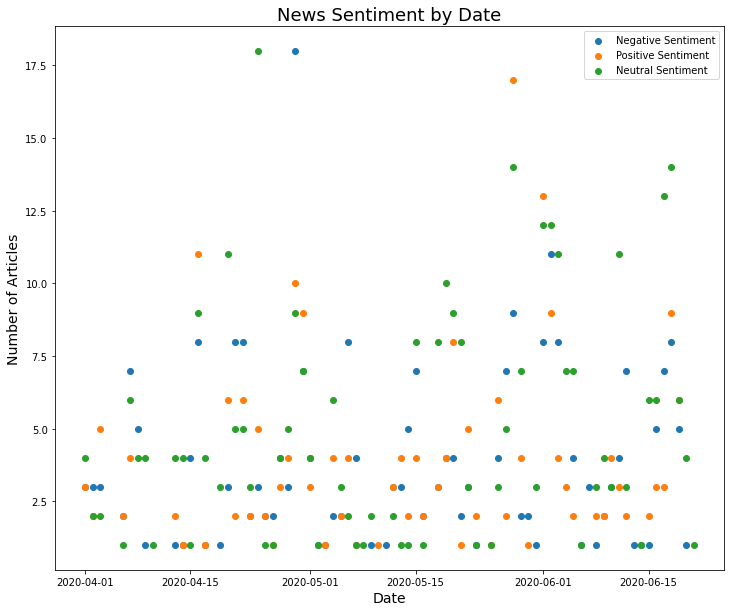

<Figure size 432x288 with 0 Axes>

In [99]:
#distribution of sentiment
plt.figure(figsize=(12,10))
plt.scatter(negative_sent_by_date.index, negative_sent_by_date.values, label='Negative Sentiment')
plt.scatter(positive_sent_by_date.index, positive_sent_by_date.values, label='Positive Sentiment')
plt.scatter(neutral_sent_by_date.index, neutral_sent_by_date.values, label='Neutral Sentiment')
plt.xlabel("Date", size=14)
plt.ylabel("Number of Articles", size=14)
plt.title("News Sentiment by Date for Facebook Over Last 2 Months", size=18)
plt.legend()
plt.show()

In [112]:
fb_curr_news_df['sentiment'].value_counts().index

Float64Index([0.0, -1.0, 1.0], dtype='float64')

<IPython.core.display.Javascript object>

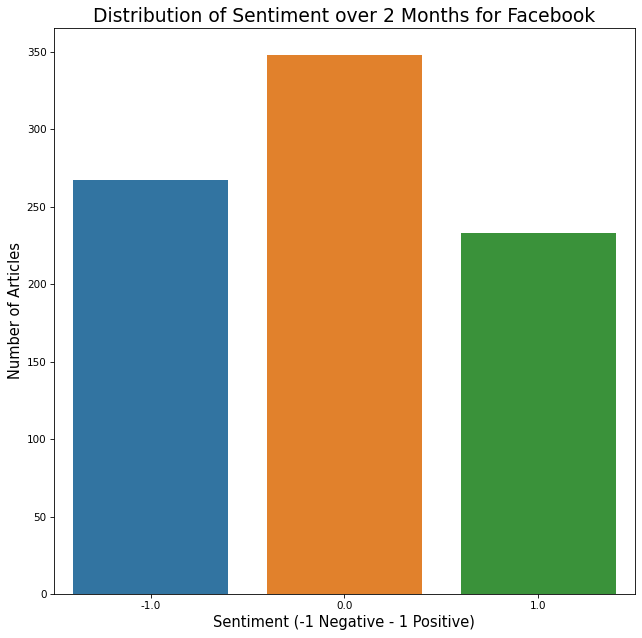

In [130]:
#distribution of sentiment
plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize']=[10, 5]
plt.rcParams['figure.dpi']=75
sns.barplot(fb_curr_news_df['sentiment'].value_counts().index, fb_curr_news_df['sentiment'].value_counts())
plt.xlabel("Sentiment (-1 Negative - 1 Positive)", size=14)
plt.ylabel("Number of Articles", size=14)
plt.title("Distribution of Sentiment over 2 Months for Facebook", size=18)
plt.show()